In [25]:
library(mmge)
library(expm)
library(fields)
library(scales)
library(abind)
library(MASS)

In [4]:
devtools::reload(pkg=".")

Reloading attached mmge



# 1. load data

In [5]:
maps = list()

In [6]:
load('Smith_LFPs_pfc_que.RData')

In [9]:
data_pfc = lapply(data, function(d){
    return(d[seq(1,dim(d)[1],5),,])
})
data_pfc = lapply(data_pfc, function(d){
    mean_d = apply(d, c(1,2), mean)
    std_d = apply(d, c(1,2), sd)
    return((d-c(mean_d))/c(std_d))
})

In [28]:
dim(data_pfc[[1]])

[1]   50   96 2000

In [12]:
maps[[1]] = map

In [15]:
load('Smith_LFPs_v4_que.RData')

In [16]:
data_v4 = lapply(data, function(d){
    return(d[seq(1,dim(d)[1],5),,])
})
data_v4 = lapply(data_v4, function(d){
    mean_d = apply(d, c(1,2), mean)
    std_d = apply(d, c(1,2), sd)
    return((d-c(mean_d))/c(std_d))
})

In [29]:
dim(data_v4[[1]])

[1]   50   96 2000

In [17]:
maps[[2]] = map

In [22]:
# PFC_map
maps[[1]][1,1]=2
maps[[1]][1,10]=14
maps[[1]][4,9]=25
maps[[1]][5,9]=21
# V4_map
maps[[2]][1,1]=2
maps[[2]][1,10]=14
maps[[2]][9,1]=79
maps[[2]][10,10]=95

In [23]:
ids = lapply(maps, function(m){
    c(m[seq(1,10,2),seq(2,10,2)])})

In [26]:
m = length(data)

In [33]:
data = lapply(1:m, function(i){
    return(abind(data_pfc[[i]][,ids[[1]],],
                 data_v4[[i]][,ids[[2]],], along=2))
})

In [35]:
m = length(data)
p = dim(data[[1]])[1]
q = dim(data[[1]])[2]

In [36]:
c(m, p, q)

[1]  5 50 50

In [37]:
ns = unlist(lapply(data, function(x){dim(x)[3]}))

In [39]:
ns

[1] 2000 2996 3000 3000 3000

In [38]:
sess.id = unlist(lapply(1:m, function(l){rep(l,ns[l])}))

# 1. estimation

In [40]:
ld = 1e-3

In [41]:
est.T = est.temporal(data, order.T=5)

In [42]:
est.S = est.spatial(data, lambdas=1e-3, verbose=TRUE)

spatial group lasso at i= 1 
spatial group lasso at i= 2 
spatial group lasso at i= 3 
spatial group lasso at i= 4 
spatial group lasso at i= 5 
spatial group lasso at i= 6 
spatial group lasso at i= 7 
spatial group lasso at i= 8 
spatial group lasso at i= 9 
spatial group lasso at i= 10 
spatial group lasso at i= 11 
spatial group lasso at i= 12 
spatial group lasso at i= 13 
spatial group lasso at i= 14 
spatial group lasso at i= 15 
spatial group lasso at i= 16 
spatial group lasso at i= 17 
spatial group lasso at i= 18 
spatial group lasso at i= 19 
spatial group lasso at i= 20 
spatial group lasso at i= 21 
spatial group lasso at i= 22 
spatial group lasso at i= 23 
spatial group lasso at i= 24 
spatial group lasso at i= 25 
spatial group lasso at i= 26 
spatial group lasso at i= 27 
spatial group lasso at i= 28 
spatial group lasso at i= 29 
spatial group lasso at i= 30 
spatial group lasso at i= 31 
spatial group lasso at i= 32 
spatial group lasso at i= 33 
spatial group lasso

In [43]:
inf.S = inf.single.edge(est.S$W.hat.S, est.T$S.hat.T, ns)

In [50]:
num.bst = 10000

In [45]:
E.mat = (matrix(0, q, q))
E.mat[1:(q/2),(q/2+1):q] = 1
E.mat = E.mat != 0

In [51]:
inf.S.multi = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                E.mat = E.mat, num.bst=num.bst)

In [52]:
# save(est.T, est.S, inf.S, inf.S.multi, file='result_btw_que.RData')

# 2. simultaneous inference result

In [53]:
inf.S.multi$p.value

[1] 0

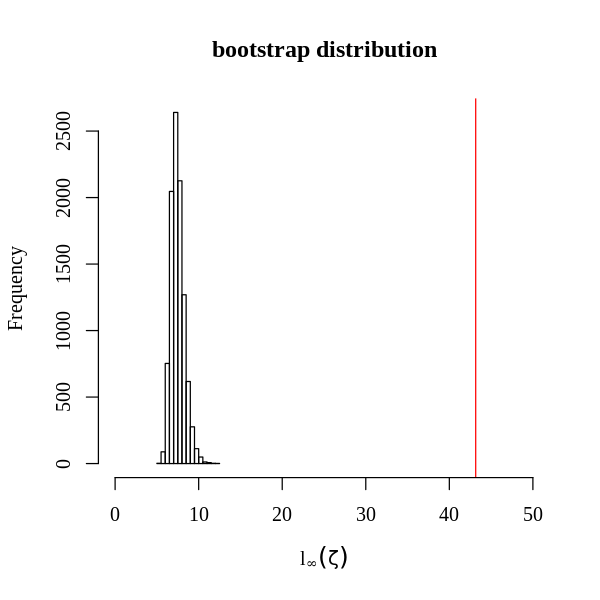

In [64]:
par(family='Times New Roman')
options(repr.plot.width=5, repr.plot.height=5)
hist(inf.S.multi$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(0, 50), xaxt="n")
abline(v = max(abs(inf.S.multi$T.hat.E[,1])), col='red')
axis(side=1, at=c(0, 10, 20, 30, 40, 50))

In [68]:
dim(inf.S$T.hat)

[1] 50 50  1

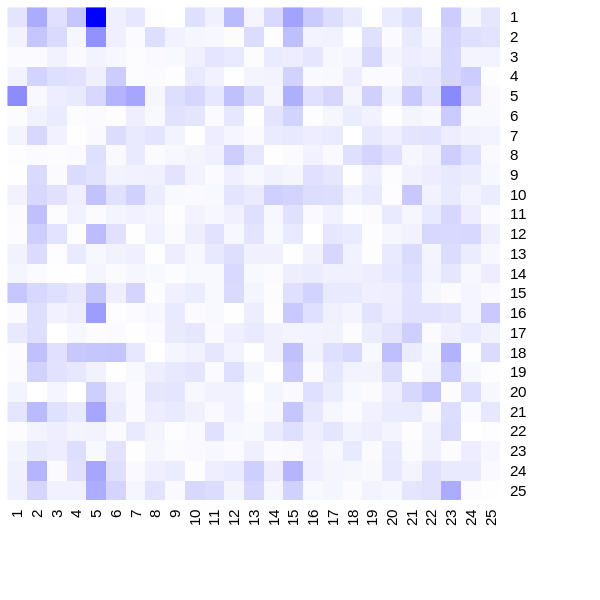

In [80]:
imshow(abs(inf.S$T.hat[1:(q/2),(q/2+1):q,1]))

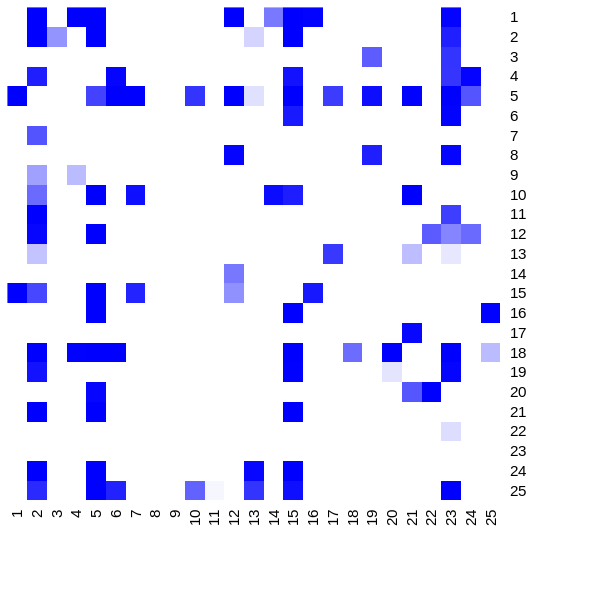

In [81]:
imshow(inf.S$p.value[1:(q/2),(q/2+1):q,1], col=BlWh.colors(256), 
       vmin=0, vmax=0.01)

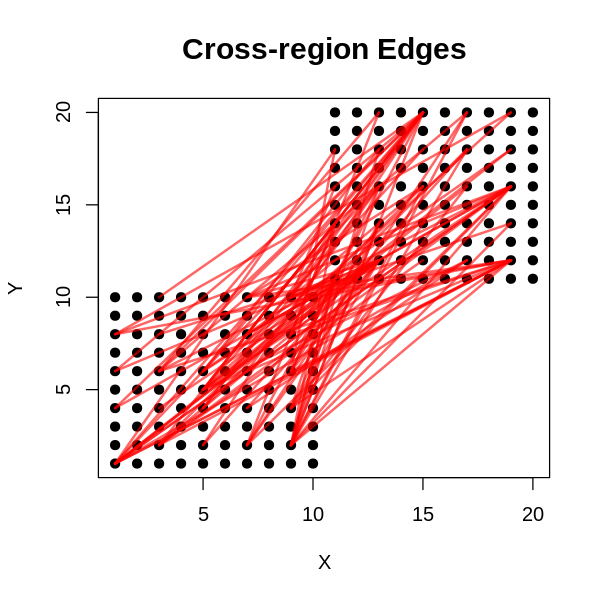

In [88]:
xys = matrix(0, nrow=200, ncol=2)
k = 1
for (i in 1:10){
    for (j in 1:10){
      xys[k,] = c(i,j)
      k = k+1
    }
}
xys[101:200,1] = xys[1:100,1]+10
xys[101:200,2] = xys[1:100,2]+10
plot(xys[,1],xys[,2], xlim = c(1,20), ylim = c(1,20), 
     type='p', pch=19, xlab = 'X', ylab = 'Y', 
     cex.main=1.5, main = 'Cross-region Edges')

for (i in 1:(q/2)){
    for (j in 1:(q/2)){
        pos1 = which(maps[[1]]==ids[[1]][i], arr.ind = T)
        pos2 = which(maps[[2]]==ids[[2]][j], arr.ind = T)
        if (inf.S$p.value[i,j+q/2,1] < 0.01){
            lines(c(pos1[1], pos2[1]+10), c(pos1[2], pos2[2]+10), col=alpha('red',0.6), lwd=2)
        }
    }
}

# 3. connectivity strength heatmap

In [89]:
maps_amp = matrix(NA, nrow=10*11, ncol=10*11)

In [99]:
for(i in 1:(q/2)){
    amp = sum(abs(inf.S$T.hat[i,(q/2+1):q,1]/sum(sqrt(ns*p/m))))
    ind = which(maps[[1]]==ids[[1]][i], arr.ind=TRUE)
    maps_amp[ind[1]*10, ind[2]*10] = amp
}

In [100]:
is = image.smooth(maps_amp, theta=10)
is$x = is$x[10:100]
is$y = is$y[10:100]
is$z = is$z[10:100,10:100]
is$x = 40*(is$x-10)
is$y = 40*(is$y-10)

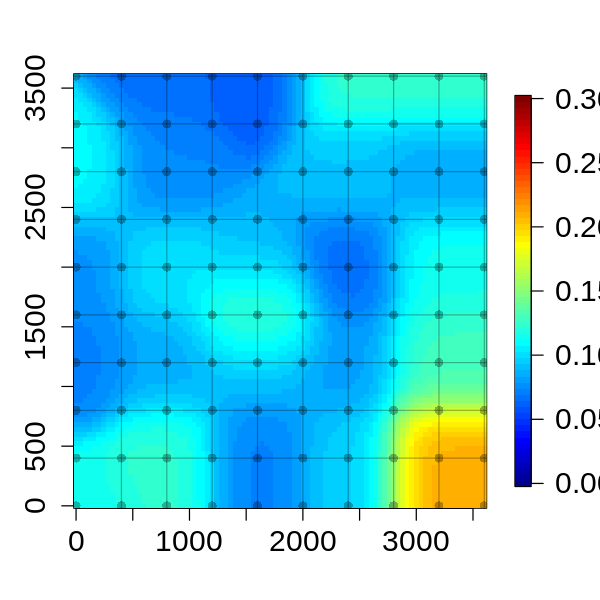

In [104]:
par(cex.axis=1.5)
image.plot(is, zlim=c(0,0.3))
for (i in 1:10){
  for (j in 1:10){
    points((i-1)*400, (j-1)*400, pch=16, lwd=0.5, col=alpha('black',0.3))
  }
  abline(h =i*400,, col=alpha('black',0.3))
  abline(v =i*400,, col=alpha('black',0.3)) 
}

In [105]:
maps_amp = matrix(NA, nrow=10*11, ncol=10*11)

In [106]:
for(i in 1:(q/2)){
    amp = sum(abs(inf.S$T.hat[1:(q/2),q/2+i,1]/sum(sqrt(ns*p/m))))
    ind = which(maps[[2]]==ids[[2]][i], arr.ind=TRUE)
    maps_amp[ind[1]*10, ind[2]*10] = amp
}

In [107]:
is = image.smooth(maps_amp, theta=10)
is$x = is$x[10:100]
is$y = is$y[10:100]
is$z = is$z[10:100,10:100]
is$x = 40*(is$x-10)
is$y = 40*(is$y-10)

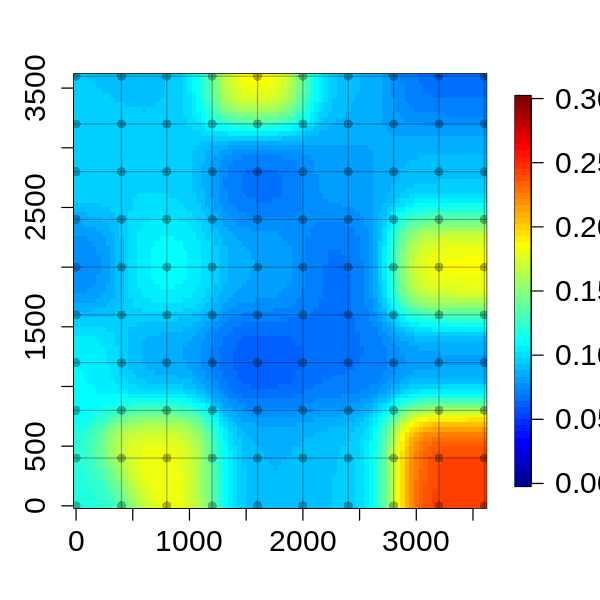

In [108]:
par(cex.axis=1.5)
image.plot(is, zlim=c(0,0.3))
for (i in 1:10){
  for (j in 1:10){
    points((i-1)*400, (j-1)*400, pch=16, lwd=0.5, col=alpha('black',0.3))
  }
  abline(h =i*400,, col=alpha('black',0.3))
  abline(v =i*400,, col=alpha('black',0.3)) 
}